In [106]:
import pandas as pd
import numpy as np
import networkx as nx
import random
from scipy.stats import pearsonr
from scipy.spatial import distance
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=20,20

pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)


# days_to_assess = 77
days_to_assess = 77

Carrega a base de voos

In [107]:
international_flights = pd.read_csv('international_graph.csv')
international_flights = international_flights[['pais_origem', 'pais_destino', 'qtde_voos']]
international_flights = international_flights.set_index(['pais_origem', 'pais_destino'])

Descomentar para testes:

countries_loc = ['Brazil', 'Italy', 'China', 'United States', 'France', 'Germany', 'Iran', 'United Kingdom']
international_flights_loc = pd.DataFrame(columns=['pais_origem', 'pais_destino', 'qtde_voos'])

for index in international_flights.index:
    if index[0] in countries_loc and index[1] in countries_loc:
        df = pd.DataFrame({'pais_origem': [index[0]], 'pais_destino': [index[1]], 'qtde_voos': [float(international_flights.loc[index])]})
        international_flights_loc = international_flights_loc.append(df, ignore_index=True)

international_flights = international_flights_loc.set_index(['pais_origem', 'pais_destino'])

In [108]:
international_flights.head()

qtde_voos
pais_origem pais_destino           
Algeria     Argentina      0.001370
            Austria        0.173973
            Belgium        0.253425
            Brazil         0.021918
            Canada         0.272603

Constrói o vetor de correlação com a média de voos entre os países

In [109]:
# TODO: retirar todos os loops e substituir por expressoes em pandas (para ficar mais facil nos certificarmos que tudo esta certo)

international_flights_avg = pd.DataFrame(columns = ['source', 'target', 'value'])
indexes = international_flights.index
international_flights_avg_list = international_flights_avg[['source', 'target']].values.tolist()


for index in indexes:
    if list(index) not in international_flights_avg_list:
        if (index[1], index[0]) not in indexes:
            value_1 = [[index[0], index[1], international_flights.loc[(index[0], index[1])].qtde_voos]]
            value_2 = [[index[1], index[0], international_flights.loc[(index[0], index[1])].qtde_voos]]
        else:
            base_value =  (international_flights.loc[(index[0], index[1])].qtde_voos + international_flights.loc[(index[1], index[0])].qtde_voos)/2
            value_1 = [[index[0], index[1], base_value]]
            value_2 = [[index[1], index[0], base_value]]

        df = pd.DataFrame(value_1, columns=['source', 'target', 'value'])
        international_flights_avg = international_flights_avg.append(df, ignore_index = True)
        df = pd.DataFrame(value_2, columns=['source', 'target', 'value'])
        international_flights_avg = international_flights_avg.append(df, ignore_index = True) 
        
        international_flights_avg_list = international_flights_avg[['source', 'target']].values.tolist()
        

In [110]:
international_flights_avg.to_csv('transition_matrix_edge_list.csv', index=False)
international_flights_avg.head()

,source,target,value
0,Algeria,Argentina,0.005479
1,Argentina,Algeria,0.005479
2,Algeria,Austria,0.141781
3,Austria,Algeria,0.141781
4,Algeria,Belgium,0.307534


Constrói o grafo com a probabilidade de voos entre países

In [111]:
country_international_flights = international_flights_avg.groupby(['source']).sum() 
transition_matrix = international_flights_avg.copy()
transition_matrix = transition_matrix.drop(columns= ['value'])

transition_matrix['prob'] = 0.

for index, row in international_flights_avg.iterrows():
    weight = float(country_international_flights.loc[row['source']])
    transition_matrix.loc[index,'prob'] = row['value']/weight


In [112]:

transition_matrix.head()

,source,target,prob
0,Algeria,Argentina,0.000300
1,Argentina,Algeria,0.000166
2,Algeria,Austria,0.007769
3,Austria,Algeria,0.000590
4,Algeria,Belgium,0.016851


In [113]:
transition_matrix_crosstab = pd.crosstab(transition_matrix['target'], transition_matrix['source'], transition_matrix['prob'], aggfunc=sum)
transition_matrix_crosstab = transition_matrix_crosstab.fillna(0)

In [114]:
transition_matrix_crosstab

source,Algeria,Anguilla,Argentina,Armenia,Aruba,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Bermuda,Bolivia,Bosnia and Herzegovina,Brazil,British Virgin Islands,Brunei,Bulgaria,Canada,Cape Verde,Chile,China,Colombia,Costa Rica,Croatia,Cyprus,Czech Republic,Denmark,Dominican Republic,Ecuador,Egypt,Estonia,Finland,France,French Polynesia,Gambia,Georgia,Germany,Gibraltar,Greece,Grenada,Guatemala,Guernsey,Guinea,Guinea-Bissau,Haiti,...,New Caledonia,New Zealand,Norway,Oman,Pakistan,Palestine,Panama,Peru,Philippines,Poland,Portugal,Puerto Rico,Qatar,Reunion,Romania,Russia,Saint Lucia,Saint Pierre and Miquelon,Saint Vincent and the Grenadines,Saudi Arabia,Senegal,Serbia,Singapore,Slovakia,Slovenia,South Africa,South Korea,Spain,Sri Lanka,Suriname,Sweden,Switzerland,Taiwan,Tajikistan,Thailand,Trinidad and Tobago,Tunisia,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Virgin Islands,West Bank,Western Sahara,Zambia
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Algeria,0.000000,0.0,0.000166,0.000000,0.000000,0.000000,0.000590,0.000000,0.000000,0.000128,0.000345,0.000000,0.000000,0.001642,0.0,0.000000,0.000000,0.000000,0.000325,0.000000,0.000000,0.000000,0.000801,0.000000,0.000000,0.000000,0.000245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001887,0.000000,0.000000,0.015935,0.000000,0.000933,0.000000,0.000561,0.000000,0.000048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000018,0.000000,0.001307,0.0,0.000000,0.000000,0.000101,0.000000,0.000570,0.000000,0.003217,0.000000,0.000000,0.000244,0.000000,0.000000,0.000000,0.001162,0.028759,0.000077,0.000000,0.000000,0.000000,0.000166,0.000000,0.003552,0.000000,0.000000,0.000013,0.000813,0.000000,0.000000,0.000000,0.000000,0.000816,0.005329,0.000000,0.002236,0.000451,0.000012,0.000307,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Anguilla,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Argentina,0.000300,0.0,0.000000,0.000000,0.000466,0.000675,0.000006,0.000000,0.000000,0.000000,0.002070,0.000000,0.000000,0.000135,0.0,0.000239,0.197832,0.000000,0.180545,0.000000,0.000000,0.000000,0.001356,0.001987,0.208369,0.000000,0.020421,0.006727,0.000000,0.000000,0.000038,0.000000,0.019744,0.064713,0.000000,0.000000,0.000000,0.001056,0.000960,0.000000,0.000000,0.000571,0.000000,0.000019,0.000000,0.003895,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.005641,0.000000,0.000000,0.000000,0.0,0.026452,0.098779,0.000081,0.000025,0.000027,0.000897,0.000047,0.017647,0.000000,0.000050,0.000000,0.000000,0.000000,0.000038,0.002801,0.000000,0.000000,0.000000,0.000000,0.000222,0.000029,0.006148,0.000000,0.000000,0.000006,0.000350,0.000000,0.000000,0.000019,0.000000,0.000148,0.000016,0.000000,0.000016,0.000894,0.008633,0.302989,0.000000,0.084052,0.000000,0.000000,0.000000,0.0,0.000000
Armenia,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000097,0.000000,0.000000,0.000000,0.000000,0.000000,0.001911,0.000011,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

Carrega o arquivo com o total diário de casos e pega o dia específico - 77

In [115]:
total_cases = pd.read_csv('total_cases_countries_normalized.csv')
total_cases = total_cases[['Name', 'Day', 'Total']].set_index(['Name', 'Day'])

countries = transition_matrix_crosstab.columns.to_list()

indexes = []
for index in total_cases.index:
    indexes.append(index)

daily_cases = pd.DataFrame(columns=['n_cases'], index=[countries])

for country in countries:
    if (country, days_to_assess) not in indexes:
        daily_cases.loc[country, 'n_cases'] = 0. 
    else:
        daily_cases.loc[country, 'n_cases'] = total_cases.loc[country, days_to_assess][0]

In [116]:
total_cases

Total
Name        Day       
Afghanistan 0      0.0
            1      0.0
            2      0.0
            3      0.0
            4      0.0
...                ...
Zimbabwe    135   37.0
            136   37.0
            137   42.0
            138   44.0
            139   46.0

[17427 rows x 1 columns]

In [117]:
#TODO: os nomes das df de voos e  casos parecem estar muito diferentes. eh preciso normaliza-los... veja que tem muito valor nulo no vetor abaixo

state_df_start = total_cases.xs(0, level=1).reindex(transition_matrix_crosstab.columns)

state_df_start

,Total
source,
Algeria,0.0
Anguilla,NaN
Argentina,NaN
Armenia,0.0
Aruba,NaN
Australia,0.0
Austria,0.0
Azerbaijan,0.0
Bahamas,NaN


In [118]:
state_df_start = state_df_start.fillna(0)

state_df_start

,Total
source,
Algeria,0.0
Anguilla,0.0
Argentina,0.0
Armenia,0.0
Aruba,0.0
Australia,0.0
Austria,0.0
Azerbaijan,0.0
Bahamas,0.0


In [119]:
daily_cases

,n_cases
Algeria,58
Anguilla,0
Argentina,65
Armenia,52
Aruba,2
Australia,375
Austria,1016
Azerbaijan,19
Bahamas,1
Bahrain,221


In [120]:
#TODO: daily_cases tem tuplas como indice. ajustar la em cima para que o indice seja simplesmente o nome do pais (nao fazendo essa gambiarra que fiz mas sim usando o pandas do jeito certo para que isto nao aconteca)

daily_cases.index = [x[0] for x in daily_cases.rename_axis("source").index]

daily_cases['n_cases'] = daily_cases['n_cases'].astype(float)

daily_cases

,n_cases
Algeria,58.0
Anguilla,0.0
Argentina,65.0
Armenia,52.0
Aruba,2.0
Australia,375.0
Austria,1016.0
Azerbaijan,19.0
Bahamas,1.0
Bahrain,221.0


Faz o random walk

In [121]:
def new_state_df(initial_number, transition_matrix_crosstab):

    state_df = pd.DataFrame(index=transition_matrix_crosstab.columns, columns = ['n_cases'])

    for country in state_df.index:
        if country == 'China':
            state_df.loc[country, 'n_cases'] = float(initial_number)
        else:
            state_df.loc[country, 'n_cases'] = 0.
            
    return state_df


Cria o dataframe a ser utilizado e roda o gridsearch

In [122]:

def model_spread2(r, p):
    state_df = state_df_start #new_state_df(v, transition_matrix_crosstab)
#     state_df = transition_matrix_crosstab.dot(state_df)
    for i in range(1, days_to_assess + 1):
        state_df = state_df*r + (transition_matrix_crosstab.dot(state_df)*p)
    return state_df



In [123]:
from scipy.optimize import leastsq
import numpy as np
import matplotlib.pyplot as plt
import math


# function we would like to fit
func=lambda tpl : model_spread2(tpl[0], tpl[1]).T.values[0]
# ErrorFunc is the diference between the func and the y "experimental" data
ErrorFunc=lambda tpl,cases: func(tpl)-cases # np.sqrt(np.abs(func(tpl)-cases))
#tplInitial contains the "first guess" of the parameters 
tplInitial1=(1.001,0.0000001)
# leastsq finds the set of parameters in the tuple tpl that minimizes
# ErrorFunc=yfit-yExperimental
tplFinal1,success=leastsq(ErrorFunc,tplInitial1[:],args=(daily_cases.T.values[0]))
print(" params ",tplFinal1)


state_df_final=pd.DataFrame({'CasesPredicted':func(tplFinal1)}, index=transition_matrix_crosstab.columns)



 params  [1.10956337 0.00487674]


In [124]:
# from scipy.optimize import least_squares
# import numpy as np
# import matplotlib.pyplot as plt


# # function we would like to fit
# func=lambda tpl : model_spread2(tpl[0], tpl[1]).T.values[0]
# # ErrorFunc is the diference between the func and the y "experimental" data
# ErrorFunc=lambda tpl: func(tpl)-daily_cases.T.values[0]
# #tplInitial contains the "first guess" of the parameters 
# tplInitial1=(1.001,0.0000001)
# # leastsq finds the set of parameters in the tuple tpl that minimizes
# # ErrorFunc=yfit-yExperimental
# res =least_squares(ErrorFunc,tplInitial1[:], loss='cauchy')
# print(res)


# state_df_final=pd.DataFrame({'CasesPredicted':func(res['x'])}, index=transition_matrix_crosstab.columns)



In [125]:
print(state_df_final.sum())

state_df_final.sort_values('CasesPredicted', ascending=False)

CasesPredicted    113431.195418
dtype: float64


,CasesPredicted
source,
China,81010.677953
Thailand,4031.549938
South Korea,3576.641556
Taiwan,3116.694057
Malaysia,3113.691679
Japan,3013.947753
United States,2034.326410
Hong Kong,1746.746611
Philippines,1332.018460


In [126]:
print(daily_cases.sum())

daily_cases.sort_values('n_cases', ascending=False)

n_cases    183806.0
dtype: float64


,n_cases
China,81063.0
Italy,27980.0
Iran,14991.0
Spain,13994.0
South Korea,8320.0
France,6633.0
Germany,6012.0
United States,4661.0
Switzerland,2200.0
United Kingdom,1543.0


In [127]:
pearsonr(state_df_final['CasesPredicted'].values, daily_cases['n_cases'].values)

(0.9125183873559373, 3.2644834425552185e-56)

In [128]:
pearsonr(state_df_final.T.values[0], daily_cases.T.values[0])

(0.9125183873559373, 3.2644834425552185e-56)

In [129]:
df_results = state_df_final.join(daily_cases)

df_results['Residuals'] = df_results['n_cases'] - df_results['CasesPredicted']

df_results['ResidualsAbs'] = df_results['Residuals'].abs()

df_results.sort_values('Residuals')

,CasesPredicted,n_cases,Residuals,ResidualsAbs
source,,,,
Thailand,4031.549938,177.0,-3854.549938,3854.549938
Taiwan,3116.694057,0.0,-3116.694057,3116.694057
Malaysia,3113.691679,553.0,-2560.691679,2560.691679
Japan,3013.947753,824.0,-2189.947753,2189.947753
Hong Kong,1746.746611,0.0,-1746.746611,1746.746611
Philippines,1332.018460,142.0,-1190.018460,1190.018460
Macau,885.630522,0.0,-885.630522,885.630522
Singapore,1120.913208,243.0,-877.913208,877.913208
Russia,773.358329,93.0,-680.358329,680.358329


In [130]:
df_results.corr()

,CasesPredicted,n_cases,Residuals,ResidualsAbs
CasesPredicted,1.000000,0.912518,-0.019324,0.003231
n_cases,0.912518,1.000000,0.391325,0.385896
Residuals,-0.019324,0.391325,1.000000,0.935982
ResidualsAbs,0.003231,0.385896,0.935982,1.000000


In [134]:
df_results.drop('China').corr()

,CasesPredicted,n_cases,Residuals,ResidualsAbs
CasesPredicted,1.000000,0.487741,0.081459,0.608105
n_cases,0.487741,1.000000,0.632101,0.798074
Residuals,0.081459,0.632101,1.000000,0.462817
ResidualsAbs,0.608105,0.798074,0.462817,1.000000


In [132]:
df_results.corr(method='kendall')

,CasesPredicted,n_cases,Residuals,ResidualsAbs
CasesPredicted,1.000000,0.495204,0.085006,0.601039
n_cases,0.495204,1.000000,0.627740,0.787984
Residuals,0.085006,0.627740,1.000000,0.467186
ResidualsAbs,0.601039,0.787984,0.467186,1.000000


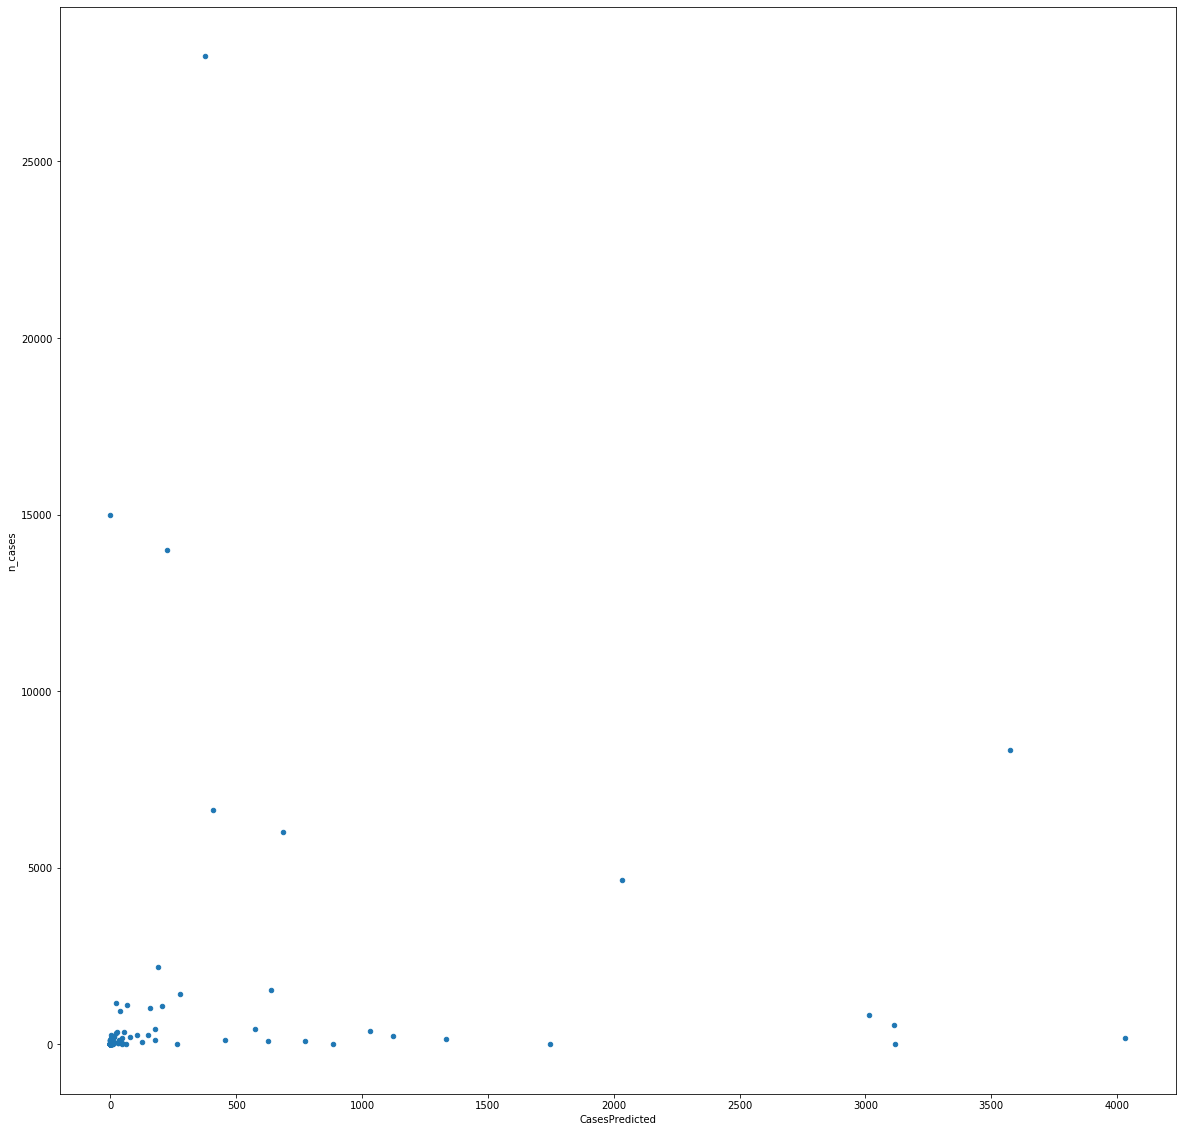

In [133]:
df_results.drop('China').plot.scatter(x='CasesPredicted', y='n_cases')